In [1]:
import pandas as pd 
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/tmp/ipykernel_6766/79180119.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## à extraire de ce champ commentaire pour en faire de nouveaux :

    présence d'allergène
    dosage min
    dosage max
    novel food (booléan) si oui, date d'entrée dans le catalogue et URL vers texte en question
    avertissements à mentionner sur l'étiquette
    avertissements sur les populations cibles
    avis ANSES et URL vers le lien de l'avis; sa date; les mises à jour
    avis EMA
    les synonymes (déjà présent dans la base, mais alimenter ce champ à partir des infos contenues dans comm)


In [2]:
INGREDIENTS = {
    "REF_ICA_INGREDIENT_AUTRE.csv",
    "REF_ICA_MICRO_ORGANISME.csv",
    "REF_ICA_PLANTE.csv",
    "REF_ICA_SUBSTANCE_ACTIVE.csv",
}

In [3]:
ingredient_df = pd.read_csv('../raw_data/REF_ICA_INGREDIENT_AUTRE.csv')
ingredient_df['INGA_COMMENTAIRE_PUBLIC']

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                                     NaN
                              ...                        
1166                                                  NaN
1167    La quantité de chondroïtine par dose journaliè...
1168                                                  NaN
1169                                                  NaN
1170                                                  NaN
Name: INGA_COMMENTAIRE_PUBLIC, Length: 1171, dtype: object

In [4]:
# Merge des DF de tous les types d'ingrédients

columns_to_select = ['COMMENTAIRE_PUBLIC', 'COMMENTAIRE_PUBLIC_EN']
df_list = []
for filename in INGREDIENTS:
    df = pd.read_csv(f'../raw_data/{filename}')
    columns = [column_name for column_name in df.columns if column_name.split('_', 1)[1] in columns_to_select]
    df = df[columns]
    ingr_type = df.columns[0].split('_')[0]
    df.columns = columns_to_select
    df['TYPE'] = ingr_type
    df_list.append(df)

all_ingredient_df = pd.concat(df_list)
all_ingredient_df

,COMMENTAIRE_PUBLIC,COMMENTAIRE_PUBLIC_EN,TYPE
0,NaN,NaN,INGA
1,NaN,NaN,INGA
2,NaN,NaN,INGA
3,NaN,NaN,INGA
4,NaN,NaN,INGA
...,...,...,...
86,NaN,NaN,MORG
87,NaN,NaN,MORG
88,NaN,NaN,MORG
89,NaN,NaN,MORG


In [5]:
# Regexp AVIS Anses/EMA

def contains_elements_to_find(comment, elements_to_find):
    if pd.isnull(comment):
        return np.nan
    if any(elem for elem in elements_to_find  if comment.lower().find(elem) != -1):
        return True
    else:
        return False

ingredient_df['contains_ANSES'] = ingredient_df['INGA_COMMENTAIRE_PUBLIC'].apply(lambda x: contains_elements_to_find(x, ['anses']))
ingredient_df[ingredient_df['contains_ANSES'] == True]['INGA_COMMENTAIRE_PUBLIC']

228     L’Anses, dans son avis du 4 janvier 2019 (http...
291     La quantité de mélatonine par dose journalière...
296     L’Anses, dans son avis du 4 janvier 2019 (http...
339     La quantité de chondroïtine par dose journaliè...
340     La quantité de glucosamine par dose journalièr...
825     La quantité de glucosamine par dose journalièr...
1167    La quantité de chondroïtine par dose journaliè...
Name: INGA_COMMENTAIRE_PUBLIC, dtype: object

In [6]:
all_ingredient_df['contains_ANSES'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x: contains_elements_to_find(x, ['anses']))
len(all_ingredient_df[all_ingredient_df['contains_ANSES'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

72

In [7]:
   
all_ingredient_df['contains_HTTP'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x : contains_elements_to_find(x, ["http://", "https://"]))
len(all_ingredient_df[all_ingredient_df['contains_HTTP'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

29

In [8]:
   
all_ingredient_df['contains_EMA'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x : contains_elements_to_find(x, ["ema"]))
len(all_ingredient_df[all_ingredient_df['contains_EMA'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

67

In [9]:
   
all_ingredient_df['contains_allergie'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x : contains_elements_to_find(x, ["allerg"]))
len(all_ingredient_df[all_ingredient_df['contains_allergie'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

38

In [10]:
   
all_ingredient_df['contains_novel_food'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x : contains_elements_to_find(x, ["novel food"]))
len(all_ingredient_df[all_ingredient_df['contains_novel_food'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

53

In [26]:
# nombre d'occurence par mots
# ajout de stop words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
french_stopwords = list(stopwords.words('french'))

count_vectorizer_without_stopW = CountVectorizer(stop_words=french_stopwords, ngram_range=(1,1))
matrix_without_stopW = count_vectorizer_without_stopW.fit_transform(all_ingredient_df['COMMENTAIRE_PUBLIC'].dropna())
len(count_vectorizer_without_stopW.vocabulary_.items())
 
count_vectorizer = CountVectorizer(ngram_range=(1,1))
matrix = count_vectorizer.fit_transform(all_ingredient_df['COMMENTAIRE_PUBLIC'].dropna())

In [25]:
counts = pd.DataFrame([np.sum(matrix.toarray(), axis=0)],
                      columns=count_vectorizer.get_feature_names_out())
counts
# .sum(axis=0).to_frame().sort_values(by=['0'], ascending=False)

,000,0001,01,011,0111,05,06,10,100,1000000,...,évaporation,évidence,éviter,évitée,éxecution,éxécution,être,œdémateuse,œdémateuses,œuvre
0,1,1,3,1,2,1,1,26,9,1,...,1,7,7,1,1,1,175,1,3,4


In [27]:
counts_without_stopW = pd.DataFrame([np.sum(matrix_without_stopW.toarray(), axis=0)],
                      columns=count_vectorizer_without_stopW.get_feature_names_out())
counts_without_stopW

,000,0001,01,011,0111,05,06,10,100,1000000,...,évaporation,évidence,éviter,évitée,éxecution,éxécution,être,œdémateuse,œdémateuses,œuvre
0,1,1,3,1,2,1,1,26,9,1,...,1,7,7,1,1,1,175,1,3,4


In [28]:
counts.T.sort_values(by=0, ascending=False).head(20)

,0
de,957
la,653
en,581
est,524
les,472
et,325
déconseillé,275
aux,267
des,265
doit,248


In [29]:
counts_without_stopW.T.sort_values(by=0, ascending=False).head(20)

,0
déconseillé,275
doit,248
femmes,227
surveiller,225
emploi,222
enceintes,216
chez,216
concentration,201
être,175
personnes,166


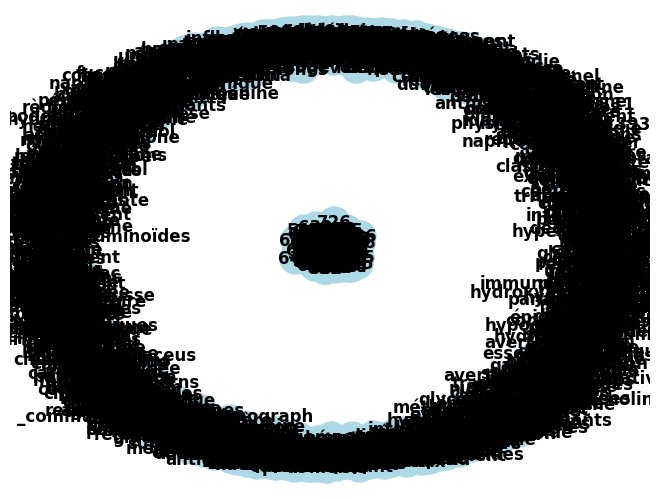

In [31]:
# ça prend 5 minutes de traitement
import networkx as nx
graph = nx.Graph()

num_nodes = len(matrix_without_stopW.toarray())

graph.add_nodes_from(count_vectorizer_without_stopW.get_feature_names_out())
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if matrix_without_stopW.toarray()[i][j] == 1:
            graph.add_edge(i, j)

nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_weight='bold')

plt.show()

In [ ]:
# TF-IDF



from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer()
x = v.fit_transform(all_ingredient_df['COMMENTAIRE_PUBLIC'].dropna())
x.toarray()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# TODO : multi-label clustering
# un document peut se retrouver dans plusieurs clusters (ANSES et AME en même temps, ou ANSES et par population)